In [134]:
import pandas as pd
import io
import re
import csv
import json
import numpy as np
from tqdm import tqdm
import math
import ast
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import seaborn as sns
import keras
from keras import backend as K
from progressbar import ProgressBar
import matplotlib.pyplot as plt
from keras import Sequential, Model
from random import randrange
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing as preprocessing
from keras.utils.vis_utils import plot_model
import time
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

from plot_figures import save_model

pbar = ProgressBar()
tqdm.pandas()

In [136]:


max_blocks = 37 #(36 + 1 FC layer at the end)
#max_blocks = 36

nb_param =21
#nb_param =13
nb_hw_param = 6
#nb_param =12

inversed = True
only_inversed = False

if inversed and not only_inversed:
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/with_inversed_hw"
elif only_inversed:
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/only_inversed_hw"
else : 
    path_entire_model= "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/no_inversed_hw"

BATCH_SIZE = 2048
SHUFFLE_BUFFER_SIZE = 100

DATASET_SIZE = 168308
train_size = int(0.90 * DATASET_SIZE) #135 805
test_size = int(0.10 * DATASET_SIZE) # 15 089

nb_training_batches = train_size //BATCH_SIZE +1
nb_test_batches = test_size //BATCH_SIZE +1

In [137]:
if inversed and not only_inversed:
    print(1)
elif only_inversed:
    print(2)
else : 
    print(3)

1


In [138]:

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.asarray(ast.literal_eval(array_string))

# Load Proccessed Neural Networks (without HyperParameters)

In [139]:

path_raw_val = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/parsed_nondups_val_all.csv'
path_raw_train = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/data/parsed_nondups_train_all.csv'

#path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/val_13.csv'
#path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/train_13.csv'


path_processed_val_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/val_21.csv'
path_processed_train_nn = '/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/train_21.csv'


In [140]:
#%pycache
tin= time.clock()

    
val = pd.read_csv(path_processed_val_nn,converters={'NN_dataframe': from_np_array})
train = pd.read_csv(path_processed_train_nn,converters={'NN_dataframe': from_np_array})

tfin= time.clock()
print(f'Total time : {(tfin-tin)/60} min')

Total time : 0.2894863833333147 min


# Complete to zeros (max shape)

In [141]:
def add_zero_blocks(arr):
    zero_blocks = np.zeros((max_blocks-arr.shape[0],arr.shape[1]))
    return np.append(arr, zero_blocks, axis=0)

val['NN_dataframe']= val['NN_dataframe'].apply(lambda x : add_zero_blocks(x))
train['NN_dataframe']= train['NN_dataframe'].apply(lambda x : add_zero_blocks(x))



# Get y_train, y_val


In [142]:
# To retrieve y_train / y_test

train_hw = pd.read_csv(path_raw_train)
val_hw = pd.read_csv(path_raw_val)

y_train = np.array(train_hw["total_power"].tolist())
y_train=y_train.reshape(y_train.shape[0],-1)

y_val = np.array(val_hw["total_power"].tolist())
y_val=y_val.reshape(y_val.shape[0],-1)

--------
# HW PARAM ALONE

In [143]:
X_train_hw_param  = train_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_train_hw_param['tot_mac'] = X_train_hw_param['mac_num']*X_train_hw_param['mac_array_num']

X_val_hw_param  = val_hw[['mac_num', 'mac_array_num', 'data_bits', 'sram_size', 'max_filter_size']]
X_val_hw_param['tot_mac'] = X_val_hw_param['mac_num']*X_val_hw_param['mac_array_num']

X_train_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac
0,118.0,2.0,256.0,179968.0,2048.0,236.0
1,87.0,2.0,512.0,99968.0,2048.0,174.0
2,124.0,2.0,512.0,99968.0,3072.0,248.0
3,80.0,2.0,1024.0,99968.0,1024.0,160.0
4,86.0,2.0,512.0,60000.0,1536.0,172.0


# Inv

In [144]:
def inv(x):
    return 1/(1+x)


if inversed : 
#nb_hw_param = 6
    nb_hw_param = 12
    X_train_hw_param['1/mac_num'] = X_train_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/mac_array_num'] = X_train_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/data_bits'] = X_train_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/sram_size'] = X_train_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/max_filter_size'] = X_train_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_train_hw_param['1/tot_mac'] = X_train_hw_param['tot_mac'].progress_apply(lambda x : inv(x))


    X_val_hw_param['1/mac_num'] = X_val_hw_param['mac_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/mac_array_num'] = X_val_hw_param['mac_array_num'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/data_bits'] = X_val_hw_param['data_bits'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/sram_size'] = X_val_hw_param['sram_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/max_filter_size'] = X_val_hw_param['max_filter_size'].progress_apply(lambda x : inv(x))
    X_val_hw_param['1/tot_mac'] = X_val_hw_param['tot_mac'].progress_apply(lambda x : inv(x))

if only_inversed : 
    nb_hw_param = 6
    inv = ['1/mac_num','1/mac_array_num','1/data_bits','1/sram_size','1/max_filter_size','1/tot_mac']
    X_train_hw_param =X_train_hw_param.loc[:, inv]
    X_val_hw_param =X_val_hw_param.loc[:, inv]


100%|██████████| 16686/16686 [00:00<00:00, 495028.62it/s]


In [145]:
X_val_hw_param.head()

,mac_num,mac_array_num,data_bits,sram_size,max_filter_size,tot_mac,1/mac_num,1/mac_array_num,1/data_bits,1/sram_size,1/max_filter_size,1/tot_mac
0,37.0,2.0,128.0,199936.0,4098.0,74.0,0.026316,0.333333,0.007752,0.000005,0.000244,0.013333
1,91.0,2.0,256.0,119936.0,2048.0,182.0,0.010870,0.333333,0.003891,0.000008,0.000488,0.005464
2,74.0,2.0,256.0,139904.0,1024.0,148.0,0.013333,0.333333,0.003891,0.000007,0.000976,0.006711
3,70.0,2.0,512.0,80000.0,512.0,140.0,0.014085,0.333333,0.001949,0.000012,0.001949,0.007092
4,103.0,2.0,256.0,199936.0,4098.0,206.0,0.009615,0.333333,0.003891,0.000005,0.000244,0.004831


## HW Normalize

In [146]:
# normalize

#%pycache
# Process
scaler = preprocessing.StandardScaler().fit(X_train_hw_param)
X_train_hw_param_norm= scaler.transform(X_train_hw_param)
X_val_hw_param_norm = scaler.transform(X_val_hw_param )


## Datasets for HW param

In [147]:

X_hw_norm = np.concatenate((X_train_hw_param_norm, X_val_hw_param_norm))
X_hw = np.concatenate((X_train_hw_param, X_val_hw_param))
y = np.concatenate((y_train, y_val))

# Mix train/test
#NORMED
dataset_hw_norm = tf.data.Dataset.from_tensor_slices((X_hw_norm, y))
dataset_hw_norm= dataset_hw_norm.shuffle(SHUFFLE_BUFFER_SIZE)
#UNORMED
dataset_hw = tf.data.Dataset.from_tensor_slices((X_hw, y))
dataset_hw= dataset_hw.shuffle(SHUFFLE_BUFFER_SIZE)

# Split them
#NORMED
train_dataset_hw_norm =  dataset_hw_norm.take(train_size).batch(BATCH_SIZE)
test_dataset_hw_norm = dataset_hw_norm.skip(train_size).batch(BATCH_SIZE)

#UNORMODED
train_dataset_hw =  dataset_hw.take(train_size).batch(BATCH_SIZE)
test_dataset_hw = dataset_hw.skip(train_size).batch(BATCH_SIZE)


------------

# NN TREATEMENT ALONE

In [161]:


X_train_nn =np.array(train['NN_dataframe'].tolist())
X_val_nn = np.array(val['NN_dataframe'].tolist())

## NN Normalize

### Divde columns by standard deviation

In [162]:


means = []
std = []
X_train_nn_norm=X_train_nn
X_val_nn_norm = X_val_nn
for i in range(nb_param):
    #means.append(np.mean(X_train_nn[:,:,i]))
    #X_train_nn[:,:,i]=-means[i]
    std.append(np.std(X_train_nn[:,:,i]))
    if std[i]!=0:
        X_train_nn[:,:,i]/= std[i]
        X_val_nn[:,:,i]/= std[i]  



### Bad normalisation

In [163]:
%pycache
# #Reshape
train_reshape= X_train_nn.reshape(X_train_nn.shape[0], -1)
val_reshape= X_val_nn.reshape(X_val_nn.shape[0], -1)

# # Process
scaler = preprocessing.StandardScaler().fit(train_reshape)
train_scaled= scaler.transform(train_reshape)
val_scaled = scaler.transform(val_reshape)


#Re-reshape
X_train_nn_norm= train_scaled.reshape(X_train_nn.shape)
X_val_nn_norm= val_scaled.reshape(X_val_nn.shape)

UsageError: Line magic function `%pycache` not found.


In [164]:
std

[168699869.97915924,
 77003.80611327905,
 65036.326551814425,
 77315.81014767835,
 69.26117082806793,
 4.06852436470495,
 0.10888352694414566,
 881152.991469202,
 39.02498722138969,
 48952.943970511216,
 48952.943970511216,
 3.9024987221389695,
 1.4594594594594592,
 0.0,
 328325037.5907248,
 58764.360755012734,
 127796.3750832357,
 122444.4227460373,
 143.63853432547685,
 10.043619380044674,
 0.29786951005147344]

In [165]:
pd.DataFrame(X_train_nn_norm[0]).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.084321,0.007636,2.314522,3.407117,0.043314,2.212104,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,5.381168,5.381168,5.381168,...,5.381168,6.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.109305,0.010000,4.050413,5.678528,0.303200,0.245789,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,0.468448,0.041037,6.750689,1.622437,0.505334,2.212104,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.160465,0.038306,0.981561,1.126911,0.487334,0.896091,0.0


## Datasets for NN

In [168]:

X_nn_norm = np.concatenate((X_train_nn_norm, X_val_nn_norm))
X_nn = np.concatenate((X_train_nn, X_val_nn))
y = np.concatenate((y_train, y_val))

# Mix test/train 
#NORMED
dataset_nn_norm = tf.data.Dataset.from_tensor_slices((X_nn_norm, y))
dataset_nn_norm= dataset_nn_norm.shuffle(SHUFFLE_BUFFER_SIZE)

#UNNORMED
dataset_nn = tf.data.Dataset.from_tensor_slices((X_nn, y))
dataset_nn.shuffle(SHUFFLE_BUFFER_SIZE)


# Split them
#NORMED
test_dataset_nn_norm = dataset_nn_norm.take(test_size).batch(BATCH_SIZE)
train_dataset_nn_norm = dataset_nn_norm.skip(test_size).batch(BATCH_SIZE)

#UNORMED
test_dataset_nn= dataset_nn.take(test_size).batch(BATCH_SIZE)
train_dataset_nn = dataset_nn.skip(test_size).batch(BATCH_SIZE)

ValueError: Dimensions 17414 and 168308 are not compatible

# Full Dataset (HW_params + NN arrays)

In [ ]:
#NORMED
train_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_train_nn_norm, X_train_hw_param_norm), y_train))
test_dataset_norm = tf.data.Dataset.from_tensor_slices(((X_val_nn_norm, X_val_hw_param_norm), y_val))

#UNORMED
train_dataset = tf.data.Dataset.from_tensor_slices(((np.array(X_train_nn), np.array(X_train_hw_param)), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices(((np.array(X_val_nn), np.array(X_val_hw_param)), y_val))


### Shuffle train/test dataset

In [ ]:
#%pycache
# Mix between train/test (mix networks)
#NORMED
full_dataset_norm = train_dataset_norm.concatenate(test_dataset_norm)
full_dataset_norm = full_dataset_norm.shuffle(SHUFFLE_BUFFER_SIZE)

test_dataset_norm = full_dataset_norm.take(test_size)
train_dataset_norm = full_dataset_norm.skip(test_size)

train_dataset_norm = train_dataset_norm.batch(BATCH_SIZE)
test_dataset_norm = test_dataset_norm.batch(BATCH_SIZE)


#UNORMED
full_dataset = train_dataset.concatenate(test_dataset_norm)
full_dataset = full_dataset.shuffle(SHUFFLE_BUFFER_SIZE)

test_dataset= full_dataset.take(test_size)
train_dataset = full_dataset.skip(test_size)

train_dataset = train_dataset_norm.batch(BATCH_SIZE)
test_dataset = test_dataset_norm.batch(BATCH_SIZE)

### Small dataset

In [ ]:
#%pycache
mini_batches = 2

train_dataset_small =train_dataset.take(mini_batches).batch(BATCH_SIZE)
test_dataset_small =test_dataset.take(mini_batches).batch(BATCH_SIZE)

train_dataset_small_norm =train_dataset_norm.take(mini_batches)
test_dataset_small_norm =test_dataset_norm.take(mini_batches)

# Get loss/model

## Models

In [122]:
name_test = 'model_2'

In [123]:

 model_nn= tf.keras.Sequential([
       layers.Conv1D(128, (2), activation='relu', padding="same",input_shape=(max_blocks, nb_param)),
       layers.Conv1D(32, (2), activation='relu', padding="same"),
       #layers.Conv1D(32, (2), activation='relu', padding="same"),
       #layers.Conv1D(, (3), activation='relu', padding="same"),
       layers.Lambda( lambda x: K.sum(x, axis=1)),
      #layers.Flatten()
 ])


model_hw = tf.keras.Sequential([
     layers.Dense(32, activation='relu', input_shape=(nb_hw_param,)),
     #layers.Dropout(0.1),
     #layers.Dense(32, activation='relu'),
     #layers.Dense(16, activation='relu'),
     #layers.Dense(16, activation='relu'),
     #layers.Dropout(0.1),
     layers.Dense(32, activation='linear')
 ])

#concat = tf.keras.layers.Concatenate()([model_nn.output, model_hw.output])
concat = tf.keras.layers.multiply([model_nn.output, model_hw.output])

output = tf.keras.layers.Dense(units=16, activation='relu')(concat)
#output = tf.keras.layers.Dense(units=4, activation='relu')(output)
#output = tf.keras.layers.Dense(units=16, activation='relu')(output)
output = tf.keras.layers.Dense(units=1, activation='relu')(output)
full_model = tf.keras.Model(inputs=[model_nn.input, model_hw.input], outputs=[output])
Wsave =full_model.get_weights()

print(f'PARAMS : {full_model.count_params()}')

PARAMS : 11969


In [124]:
def loss(target_power, predicted_power):
  return tf.math.abs((target_power - predicted_power)/target_power)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Test on NN only

In [125]:
%pycache
nn_epochs = 15

t0= time.clock()


print(f'PARAMS: {model_nn.count_params()}')
model_nn.compile(optimizer=optimizer, loss=loss)

nn = model_nn.fit(train_dataset_nn_norm,
          validation_data=(test_dataset_nn_norm),
          epochs=nn_epochs,
          verbose=1,
          #callbacks=[TestCallback((test_dataset)) ] )
)
t1= time.clock()
print(f'Training NN for {nn_epochs} epochs : {(t1-t0)/60} min')

UsageError: Line magic function `%pycache` not found.


### 10 epochs :  5 mins

In [126]:
%pycache
name = f'{name_test}_{model_nn.count_params()}_param'
save = True
nb_predictions = 100
max_val_loss=4
nb_final_epochs_for_mean = 3


path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiple_inputs/test/only_NN_features"
model = model_nn
X_list = [X_val_nn_norm]
history = nn

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path, model= model, history=history, X_list=X_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean , save = save)

UsageError: Line magic function `%pycache` not found.


# Test on HW only

###
137,090 HW parameters
68,503 unique ones </br>

137,090 power estimation
121,602 unique ones

In [127]:
%pycache
hw_epochs=3
 
t2= time.clock()
print(f'PARAMS : {model_hw.count_params()}')
model_hw.compile(optimizer=optimizer, loss=loss)
hw = model_hw.fit(train_dataset_hw,
            validation_data=(test_dataset_hw),
            epochs=hw_epochs,
            verbose=1)

# hw = model_hw.fit(train_dataset_hw,
#             validation_data=(test_dataset_hw),
#             epochs=20,
#             verbose=1)

t3= time.clock()
print(f'Training HW for {hw_epochs} epochs : {(t3-t2)/60} min')

UsageError: Line magic function `%pycache` not found.


In [128]:
%pycache
name = f'{name_test}_{model_hw.count_params()}_param'
nb_predictions = 100
max_val_loss=0.30
nb_final_epochs_for_mean = 3 
save = False

path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiple_inputs/test/only_HW_features"
model = model_hw
X_list = [X_val_hw_param_norm]
history = hw

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path, model= model, history=history, X_list=X_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save = save )

UsageError: Line magic function `%pycache` not found.


# Test entire model

In [129]:
full_epochs = 25

print(f'PARAMS : {full_model.count_params()}')
t4= time.clock()
full_model.compile(optimizer=optimizer, loss=loss)


# history = full_model.fit(train_dataset_small_norm,
#        validation_data=(test_dataset_small_norm),
#        epochs=full_epochs,
#       verbose=1,
# )


history = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=full_epochs,
         verbose=1,
 )

t5= time.clock()

print(f'Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')

PARAMS : 11969
Epoch 1/25
74/74 [==============================] - 32s 437ms/step - loss: 0.5918 - val_loss: 0.0000e+00
Epoch 2/25
74/74 [==============================] - 29s 394ms/step - loss: 0.3995 - val_loss: 0.4381
Epoch 3/25
74/74 [==============================] - 36s 481ms/step - loss: 0.3616 - val_loss: 0.4008
Epoch 4/25
74/74 [==============================] - 26s 355ms/step - loss: 0.3291 - val_loss: 0.3935
Epoch 5/25
74/74 [==============================] - 26s 346ms/step - loss: 0.3004 - val_loss: 0.3285
Epoch 6/25
74/74 [==============================] - 26s 352ms/step - loss: 0.2759 - val_loss: 0.2941
Epoch 7/25
74/74 [==============================] - 25s 343ms/step - loss: 0.2516 - val_loss: 0.2555
Epoch 8/25
74/74 [==============================] - 25s 339ms/step - loss: 0.2386 - val_loss: 0.2492
Epoch 9/25
74/74 [==============================] - 25s 339ms/step - loss: 0.2287 - val_loss: 0.2427
Epoch 10/25
74/74 [==============================] - 25s 337ms/step - lo

In [130]:
#%pycache
print(f'PARAMS : {full_model.count_params()}')
history_2 = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=5,
         verbose=1,
 )

PARAMS : 11969
Epoch 1/5
74/74 [==============================] - 33s 448ms/step - loss: 0.1651 - val_loss: 0.0000e+00
Epoch 2/5
74/74 [==============================] - 29s 395ms/step - loss: 0.1612 - val_loss: 0.1687
Epoch 3/5
74/74 [==============================] - 26s 356ms/step - loss: 0.1586 - val_loss: 0.1670
Epoch 4/5
74/74 [==============================] - 26s 353ms/step - loss: 0.1570 - val_loss: 0.1670
Epoch 5/5
74/74 [==============================] - 26s 352ms/step - loss: 0.1585 - val_loss: 0.1619


In [131]:
print(f'PARAMS : {full_model.count_params()}')
history_3 = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=5,
         verbose=1,
 )

PARAMS : 11969
Epoch 1/5
74/74 [==============================] - 26s 351ms/step - loss: 0.1544 - val_loss: 0.0000e+00
Epoch 2/5
74/74 [==============================] - 25s 331ms/step - loss: 0.1541 - val_loss: 0.1636
Epoch 3/5
74/74 [==============================] - 24s 330ms/step - loss: 0.1528 - val_loss: 0.1628
Epoch 4/5
74/74 [==============================] - 24s 329ms/step - loss: 0.1505 - val_loss: 0.1652
Epoch 5/5
74/74 [==============================] - 24s 329ms/step - loss: 0.1509 - val_loss: 0.1621


In [132]:
print(f'PARAMS : {full_model.count_params()}')
history_4 = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=5,
         verbose=1,
 )

PARAMS : 11969
Epoch 1/5
74/74 [==============================] - 29s 395ms/step - loss: 0.1491 - val_loss: 0.0000e+00
Epoch 2/5
74/74 [==============================] - 33s 446ms/step - loss: 0.1487 - val_loss: 0.1608
Epoch 3/5
74/74 [==============================] - 29s 398ms/step - loss: 0.1478 - val_loss: 0.1609
Epoch 4/5
74/74 [==============================] - 25s 333ms/step - loss: 0.1470 - val_loss: 0.1587
Epoch 5/5
74/74 [==============================] - 24s 328ms/step - loss: 0.1462 - val_loss: 0.1571


In [133]:
print(f'PARAMS : {full_model.count_params()}')
history_5 = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=5,
         verbose=1,
 )

PARAMS : 11969
Epoch 1/5
74/74 [==============================] - 31s 412ms/step - loss: 0.1464 - val_loss: 0.0000e+00
Epoch 2/5
74/74 [==============================] - 27s 366ms/step - loss: 0.1462 - val_loss: 0.1545
Epoch 3/5
74/74 [==============================] - 31s 413ms/step - loss: 0.1452 - val_loss: 0.1537
Epoch 4/5
74/74 [==============================] - 26s 357ms/step - loss: 0.1445 - val_loss: 0.1532
Epoch 5/5
74/74 [==============================] - 29s 390ms/step - loss: 0.1443 - val_loss: 0.1533


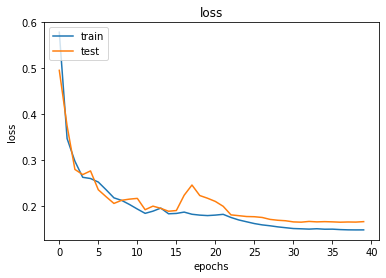

In [83]:
plt.figure()
#plt.plot(history.history["loss"]+history_2.history["loss"])
#plt.plot(history.history["val_loss"]+history_2.history["val_loss"])
plt.plot(history.history["loss"]+history_2.history["loss"]+history_3.history["loss"])
plt.plot(history.history["val_loss"]+history_2.history["val_loss"]+history_3.history["val_loss"])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')

## 10,785 params:
### 25 epochs : 56 min
### 15 epochs : 34 min
</br>

## 31 000
### **20 epochs : 25 min**
 </br>

## 57,009 params
### 20 epochs : 101 min 
</br>

##62,465 pames
### 30 epochs : 78 min
 </br>

## 143,345 params
### 20 epochs : 276 min 
</br>



PARAMS : 14241
Index : 8116
pred : [[9.283976]]
true : [17.21796471]
loss : [[0.46079715]]

Index : 14693
pred : [[239.00134]]
true : [263.92895717]
loss : [[0.0944482]]

Index : 9828
pred : [[256.32434]]
true : [244.5465441]
loss : [[0.04816178]]

Index : 15716
pred : [[151.68372]]
true : [116.50945571]
loss : [[0.30190048]]

Index : 10386
pred : [[14.04196]]
true : [13.81326986]
loss : [[0.01655581]]

Index : 9635
pred : [[5.397109]]
true : [5.28083258]
loss : [[0.02201858]]

Index : 11614
pred : [[15.412313]]
true : [10.09160483]
loss : [[0.52724108]]

Index : 8334
pred : [[8.919998]]
true : [17.17696453]
loss : [[0.48069997]]

Index : 1816
pred : [[15.556244]]
true : [13.16184469]
loss : [[0.18191973]]

Index : 6110
pred : [[13.073763]]
true : [14.7338156]
loss : [[0.11266957]]

Index : 1765
pred : [[16.134096]]
true : [17.02152688]
loss : [[0.05213579]]

Index : 9747
pred : [[4.976376]]
true : [5.05430652]
loss : [[0.01541863]]

Index : 4694
pred : [[72.15497]]
true : [71.46385318

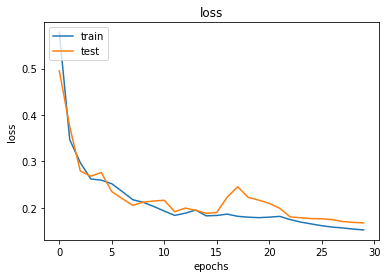

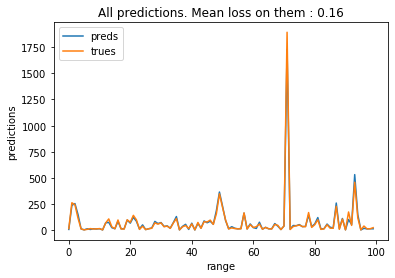

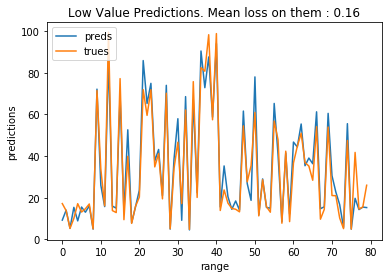

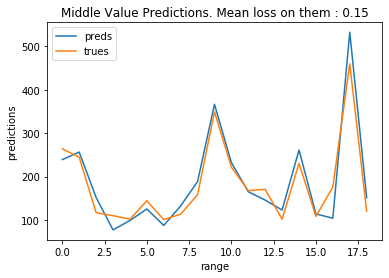

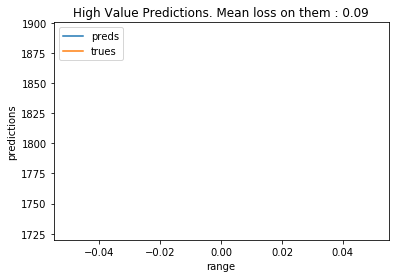

In [85]:
t5= time.clock()
nb_final_epochs_for_mean = 5
print(f'PARAMS : {full_model.count_params()}')
name = f'{name_test}_{full_model.count_params()}_param'
save = True

nb_predictions = 100
max_val_loss=0.5



model = full_model
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]
history = history

#model = full_model
#X_list = [X_val_hw_param_norm, X_val_nn_norm]

save_model(path=path_entire_model, model= model, history=history, X_list=X_val_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)


t6= time.clock()


In [43]:
print(f'Total time : {(t6-t5)/60} min')

Total time : 48.24205523333333 min


In [279]:
checkpoint_path = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/multiply/with_inversed_hw/model_6_17153_param_0.155_error/model_6_17153_param"


full_model.load_weights(checkpoint_path)
results = full_model.evaluate(test_dataset_norm)

9/9 [==============================] - 1s 151ms/step - loss: 0.1536


# Test size dataset - More data?

In [92]:

#%pycache
path_test_dataset = "/Users/roxanefischer/Desktop/single_path_nas/single-path-nas/HAS/results_best_models/test_size_dataset"

print(f'PARAMS : {full_model.count_params()}')
nb_final_epochs_for_mean = 5
save = True
nb_predictions = 100
max_val_loss=50
X_val_list = [X_val_nn_norm, X_val_hw_param_norm]


full_epochs = 25
test_performances = {}
percents = [0.97]
#percents = [0.25, 0.50, 0.75, 0.85, 0.90, 1]
mini_batches_list = l = [int(x * nb_training_batches) for x in percents]

for i, mini_batches in enumerate(mini_batches_list):
    print()
    full_model.set_weights(Wsave)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=nb_training_batches,
    decay_rate=0.95)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    train_dataset_percent_norm =train_dataset_norm.take(mini_batches)
    t4= time.clock()
    full_model.compile(optimizer=optimizer, loss=loss)
    
    history = full_model.fit(train_dataset_percent_norm,
            validation_data=(test_dataset_norm),
            epochs=full_epochs,
            verbose=1,
    )

    t5= time.clock()
    print(f'Mini_batch percent: {percents[i]} Training Full Model for {full_epochs} epochs : {(t5-t4)/60} min')
    name = f'percent_{percents[i]}'
    test_performances[percents[i]] =  np.mean((history.history["val_loss"][-nb_final_epochs_for_mean:]))

    save_model(path=path_test_dataset, model= full_model, history=history, X_list=X_val_list, y=y_val, name=name, nb_predictions = nb_predictions, max_val_loss=max_val_loss, nb_final_epochs_for_mean = nb_final_epochs_for_mean, save=save)



PARAMS : 32257

Epoch 1/25
71/71 [==============================] - 43s 601ms/step - loss: 0.6026 - val_loss: 0.0000e+00
Epoch 2/25
71/71 [==============================] - 40s 568ms/step - loss: 0.4343 - val_loss: 0.4559
Epoch 3/25
71/71 [==============================] - 39s 543ms/step - loss: 0.3430 - val_loss: 0.4000
Epoch 4/25
71/71 [==============================] - 36s 504ms/step - loss: 0.2861 - val_loss: 0.2597
Epoch 5/25
71/71 [==============================] - 31s 437ms/step - loss: 0.2587 - val_loss: 0.2915
Epoch 6/25
71/71 [==============================] - 36s 504ms/step - loss: 0.2456 - val_loss: 0.2803
Epoch 7/25
71/71 [==============================] - 35s 496ms/step - loss: 0.2285 - val_loss: 0.2551
Epoch 8/25
71/71 [==============================] - 30s 426ms/step - loss: 0.2194 - val_loss: 0.2242
Epoch 9/25
71/71 [==============================] - 36s 502ms/step - loss: 0.2126 - val_loss: 0.2219
Epoch 10/25
71/71 [==============================] - 31s 436ms/step - l

NameError: name 'test_performances_save' is not defined

In [96]:
print(f'PARAMS : {full_model.count_params()}')
history_2 = full_model.fit(train_dataset_norm,
         validation_data=(test_dataset_norm),
        epochs=5,
         verbose=1,
 )

PARAMS : 32257
Epoch 1/5
74/74 [==============================] - 44s 599ms/step - loss: 0.1587 - val_loss: 0.0000e+00
Epoch 2/5
74/74 [==============================] - 38s 520ms/step - loss: 0.1574 - val_loss: 0.1800
Epoch 3/5
74/74 [==============================] - 34s 457ms/step - loss: 0.1552 - val_loss: 0.1804
Epoch 4/5
74/74 [==============================] - 35s 470ms/step - loss: 0.1528 - val_loss: 0.1812
Epoch 5/5
74/74 [==============================] - 40s 536ms/step - loss: 0.1516 - val_loss: 0.1795


In [97]:
test_performances_save = {0.25: 0.2629273136456808,
 0.5: 0.23724876874023018,
 0.75: 0.21560097336769105,
 0.85: 0.19926969276534187,
 0.87: 0.18293529417779708,
 0.9: 0.17390226572752,
 0.95: 0.1793243298927943,
 0.97: 0.18094,
 1: 0.1743503441413244}

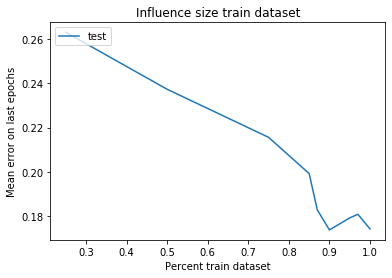

In [99]:

plt.figure()
lists = sorted(test_performances_save.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y)

plt.title('Influence size train dataset')
plt.ylabel('Mean error on last epochs')
plt.xlabel('Percent train dataset')
plt.legend(['test'], loc='upper left')